# ***Описание проекта: промышленность***

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. 

**ЦЕЛЬ РАБОТЫ** — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

**КРИТЕРИИ ОЦЕНКИ**:
    
- качество модели оцениваем по метрике MAE;

- минимальный порог для выполнения условий заказчика: MAE = 6.8.

In [2]:
#Установка последних версий
!pip install -Uq scikit-learn
!pip install phik

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01


In [3]:
#Импорт библиотек, моделей, констант
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
import time
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 100225
TEST_SIZE = 0.25

## Загрузка и подготовка данных

In [4]:
data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [5]:
def info_about(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    print(f'Количество дубликатов: {data.duplicated().sum()}')
    print(f'Количество пропусков: {data.isna().sum()}')
    display(data.corr())
    print(f'Размер: {data.shape}')
    data.hist(figsize=(12, 12))

### data_arc - данные об электродах

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Количество дубликатов: 0
Количество пропусков: key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


,key,Активная мощность,Реактивная мощность
key,1.000000,-0.010220,-0.004834
Активная мощность,-0.010220,1.000000,0.031164
Реактивная мощность,-0.004834,0.031164,1.000000


Размер: (14876, 5)


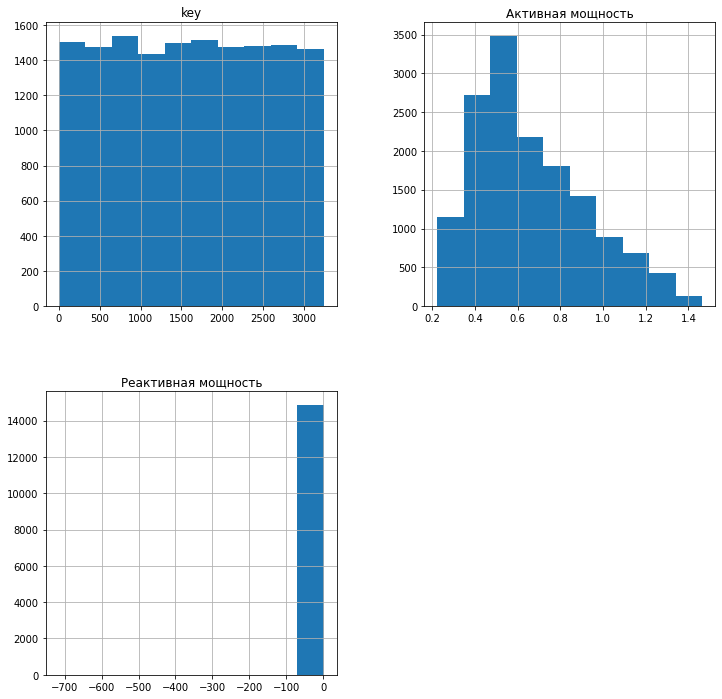

In [6]:
info_about(data_arc)

Датасет размером 14876 строк и 5 столбцов. Необходимо изменить тип данных в столбцах "Начало нагрева дугой" и "Конец нагрева дугой". Есть отрицательные значения в стобце "Реактивная мощность" (нужны ли они?). Дубликаты и пропуски отсутствуют.

### data_bulk - данные о подаче сыпучих материалов (объём)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество дубликатов: 0
Количество пропусков: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,1.000000,-0.192066,-0.038643,-0.080335,-0.101955,-0.018074,-0.063539,-0.049425,NaN,0.262741,0.288135,-0.156748,-0.030981,0.050304,-0.149840,-0.169873
Bulk 1,-0.192066,1.000000,-0.073762,0.016731,-0.040465,-0.368980,0.141745,-0.086223,NaN,NaN,-0.278055,0.461895,0.370501,1.000000,0.409188,-0.119006
Bulk 2,-0.038643,-0.073762,1.000000,NaN,0.393882,0.070350,NaN,-0.010043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,-0.080335,0.016731,NaN,1.000000,-0.260918,0.144410,0.253080,NaN,NaN,0.072850,-0.244532,0.137997,0.011648,-0.582598,0.026257,-0.023689
Bulk 4,-0.101955,-0.040465,0.393882,-0.260918,1.000000,-0.077214,-0.333841,0.324940,NaN,0.766565,-0.516399,NaN,0.051112,-0.311659,0.022925,0.041190
Bulk 5,-0.018074,-0.368980,0.070350,0.144410,-0.077214,1.000000,-0.511112,0.304476,NaN,NaN,NaN,NaN,0.007650,NaN,-0.256040,-0.248216
Bulk 6,-0.063539,0.141745,NaN,0.253080,-0.333841,-0.511112,1.000000,NaN,NaN,NaN,NaN,-0.104251,-0.079822,0.844690,0.154429,-0.038363
Bulk 7,-0.049425,-0.086223,-0.010043,NaN,0.324940,0.304476,NaN,1.000000,NaN,NaN,NaN,NaN,0.538671,NaN,1.000000,NaN
Bulk 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 9,0.262741,NaN,NaN,0.072850,0.766565,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.946954,NaN,-0.479974,NaN


Размер: (3129, 16)


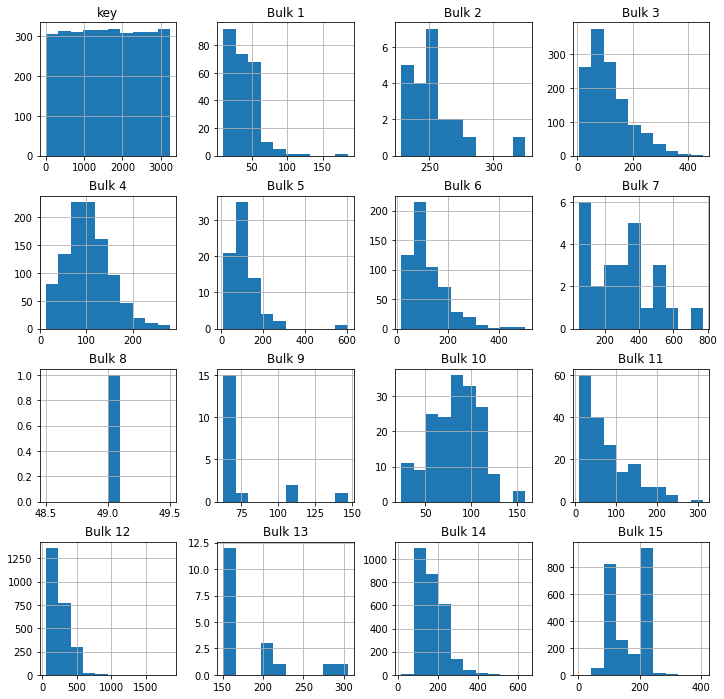

In [7]:
info_about(data_bulk)

Датасет размером 3129 строк и 16 столбцов. Типы данных в порядке. Имеется большое количество пропусков в подаваемых объемах сыпучих материалов. Дубликаты отсутствуют.

### data_bulk_time - данные о подаче сыпучих материалов (время)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество дубликатов: 0
Количество пропусков: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


,key
key,1.0


Размер: (3129, 16)


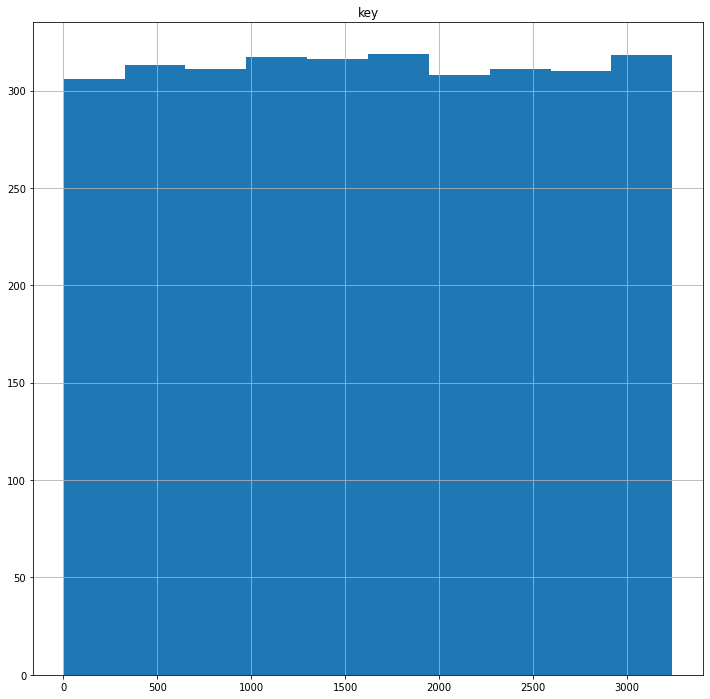

In [8]:
info_about(data_bulk_time)

Датасет размером 3129 строк и 16 столбцов. Необходимо изменить типы данных в столбцах. Имеется большое количество пропусков, схожее количество с объемом подаваемых материалов. Дубликаты отсутствуют. 

### data_gas - данные о продувке сплава газом

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество дубликатов: 0
Количество пропусков: key      0
Газ 1    0
dtype: int64


,key,Газ 1
key,1.000000,-0.040655
Газ 1,-0.040655,1.000000


Размер: (3239, 2)


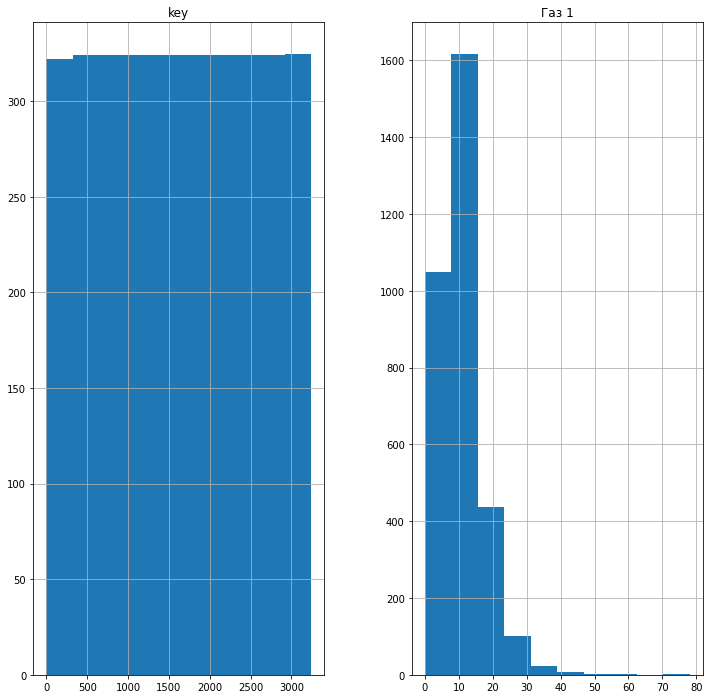

In [9]:
info_about(data_gas)

Датасет размером 3239 строк и 2 столбца. Типы данных в порядке. Дубликаты и пропуски отсутствуют. 

### data_temp - результаты измерения температуры

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


Количество дубликатов: 0
Количество пропусков: key                0
Время замера       0
Температура     3427
dtype: int64


,key,Температура
key,1.00000,-0.05627
Температура,-0.05627,1.00000


Размер: (18092, 3)


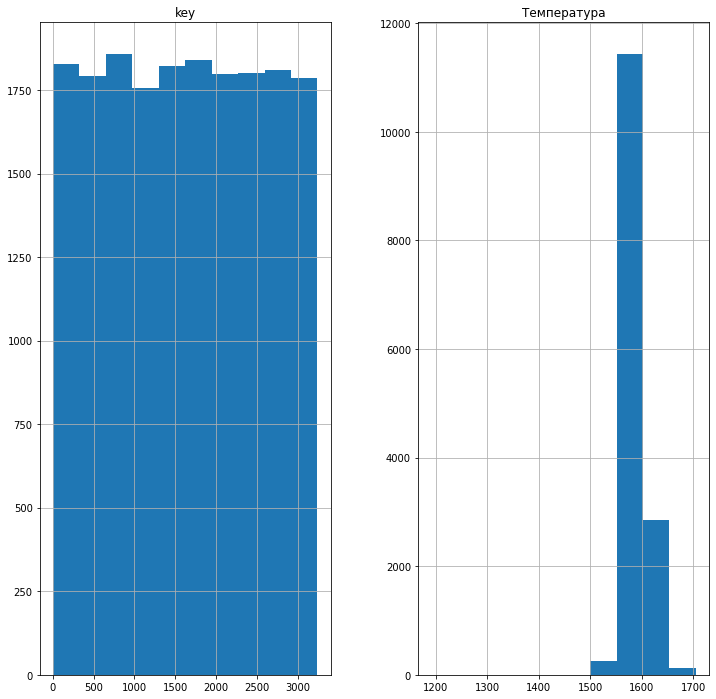

In [10]:
info_about(data_temp)

Датасет размером 18092 строк и 3 столбца. Необходимо изменить типы данных в столбце "Время замера". Имеются пропуски в столбце "Температура". Дубликаты отсутствуют.

### data_wire - данные о проволочных материалах (объём)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество дубликатов: 0
Количество пропусков: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,1.000000,-0.083352,-0.005461,-0.084460,0.389064,NaN,0.082274,0.578898,0.323891,-0.012200
Wire 1,-0.083352,1.000000,-0.030892,0.724370,0.054001,NaN,-0.280807,-0.035072,0.068697,0.010104
Wire 2,-0.005461,-0.030892,1.000000,-0.081852,NaN,NaN,-0.265706,NaN,0.250477,0.011019
Wire 3,-0.084460,0.724370,-0.081852,1.000000,0.069854,NaN,-0.221602,-0.056948,NaN,NaN
Wire 4,0.389064,0.054001,NaN,0.069854,1.000000,NaN,0.237456,-0.404865,NaN,NaN
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,0.082274,-0.280807,-0.265706,-0.221602,0.237456,NaN,1.000000,-0.224093,NaN,NaN
Wire 7,0.578898,-0.035072,NaN,-0.056948,-0.404865,NaN,-0.224093,1.000000,NaN,NaN
Wire 8,0.323891,0.068697,0.250477,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
Wire 9,-0.012200,0.010104,0.011019,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Размер: (3081, 10)


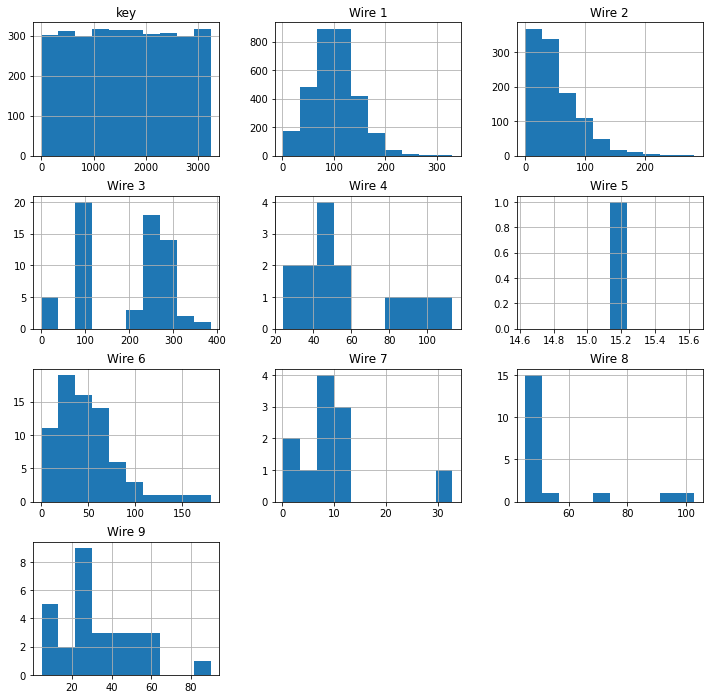

In [11]:
info_about(data_wire)

Датасет размером 3081 строк и 10 столбцов. Типы данных в порядке. Имеются пропуски в столбцах. Дубликаты отсутствуют.

### data_wire_time - данные о проволочных материалах (время)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Количество дубликатов: 0
Количество пропусков: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


,key
key,1.0


Размер: (3081, 10)


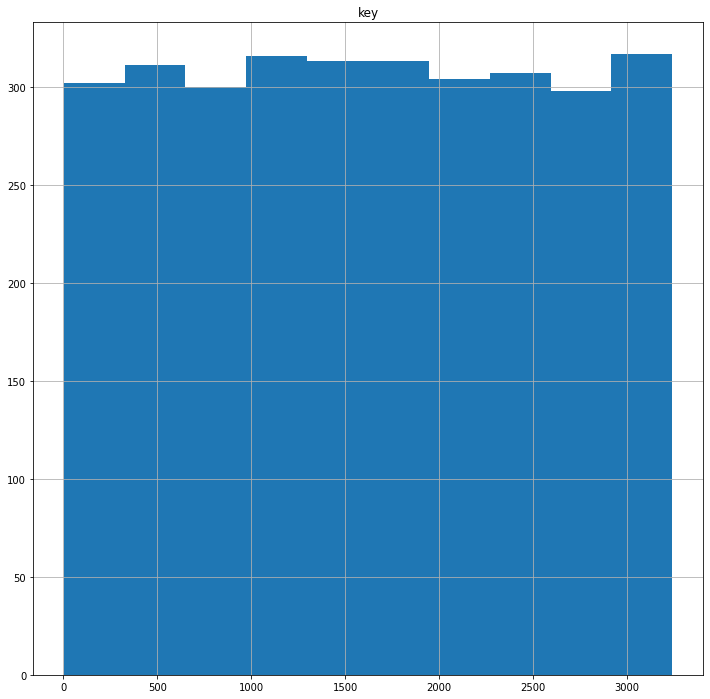

In [12]:
info_about(data_wire_time)

Датасет размером 3081 строк и 10 столбцов. Необходимо изменить типы данных в столбцах. Имеются пропуски. Дубликаты отсутствуют.

**ПРОМЕЖУТОЧНЫЙ ВЫВОД по "Загрузке и подготовке данных":** 

- имеется большое количество пропусков;

- необходимо изменить тип данных в столбцах, а именно столбцы с датами перевести в datetime;

- столбцы на разных языках, а также их необходимо привести к "змеиному регистру".

## Предобработка данных

In [13]:
# Приведем столбцы в "змеиный регистр" и к одному языку
data_arc.columns = ['key', 'start_heating','end_heating', 
                    'active_power', 'reactive_power']
data_bulk.columns = ['key', 'bulk_1', 'bulk_2',  'bulk_3', 
                     'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
                     'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 
                     'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
data_bulk_time.columns = ['key', 'bulk_1', 'bulk_2',  'bulk_3',  
                          'bulk_4',  'bulk_5', 'bulk_6', 'bulk_7',
                          'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 
                          'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
data_gas.columns = ['key', 'gas']
data_temp.columns = ['key', 'time', 'temperature']
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 
                     'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
data_wire_time.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 
                          'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

display(data_arc.columns,
       data_bulk.columns,
       data_bulk_time.columns,
       data_gas.columns,
       data_temp.columns,
       data_wire.columns,
       data_wire_time.columns)

Index(['key', 'start_heating', 'end_heating', 'active_power',
       'reactive_power'],
      dtype='object')

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Index(['key', 'gas'], dtype='object')

Index(['key', 'time', 'temperature'], dtype='object')

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [14]:
# Изменим типы данных
cols_to_convert_data_arc = ['start_heating', 'end_heating']
for col in cols_to_convert_data_arc:
    data_arc[col] = pd.to_datetime(data_arc[col])


cols_to_convert_data_bulk_time = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4',
                                  'bulk_5', 'bulk_6', 'bulk_7','bulk_8', 
                                  'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 
                                  'bulk_13', 'bulk_14', 'bulk_15']
for col in cols_to_convert_data_bulk_time:
    data_bulk_time[col] = pd.to_datetime(data_bulk_time[col])
    

data_temp['time'] = pd.to_datetime(data_temp['time'])


cols_to_convert_data_wire_time = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 
                                  'wire_5', 'wire_6', 'wire_7', 'wire_8', 
                                  'wire_9']
for col in cols_to_convert_data_wire_time:
    data_wire_time[col] = pd.to_datetime(data_wire_time[col])
    
display(data_arc.info(),
       data_bulk_time.info(),
       data_temp.info(),
       data_wire_time.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   end_heating     14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datet

None

None

None

None

**ПРОМЕЖУТОЧНЫЙ ВЫВОД по "Предобработке данных":** 

- привели столбцы к единообразию и "змеиному регистру";

- изменили типы данных в столбцах, где это необходимо;

- с пропусками поработаем в исследовательском анализе данных.

## Исследовательский анализ данных

In [15]:
def plot_histogram_boxplot(df, column):
    plt.figure(figsize=(12, 6))

    # Гистограмма
    plt.subplot(1, 2, 1)
    df[column].hist(bins=30, alpha=0.7)
    plt.title('Гистограмма')
    plt.xlabel(column)
    plt.ylabel('Частота')

    # Ящик с усами
    plt.subplot(1, 2, 2)
    plt.boxplot(df[column], vert=False)
    plt.title('Ящик с усами')
    plt.xlabel(column)

    plt.tight_layout()
    plt.show()

# data_arc

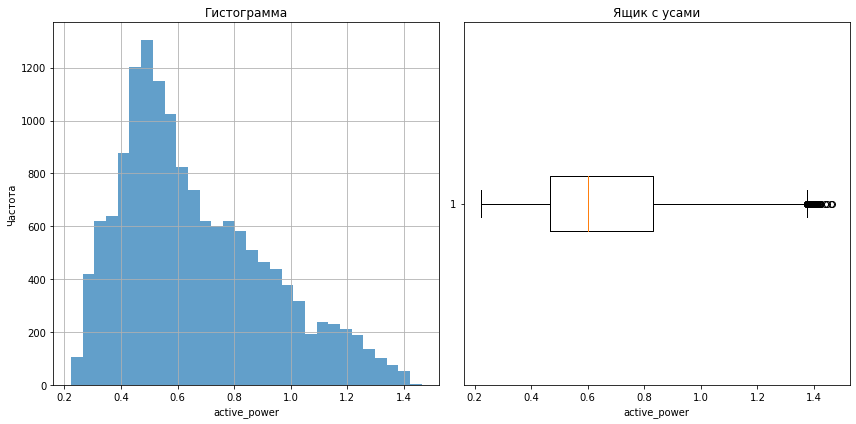

In [16]:
plot_histogram_boxplot(data_arc, 'active_power')

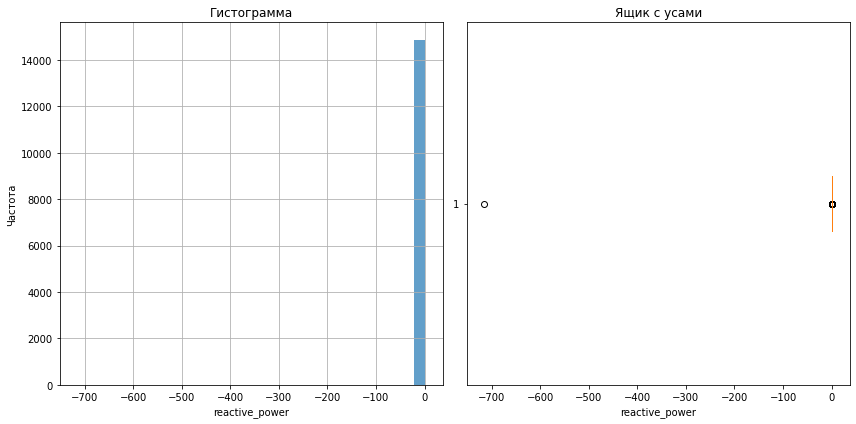

In [17]:
plot_histogram_boxplot(data_arc, 'reactive_power')

Как мы помним, в данном столбце есть аномалия с отрицательным значением, избавимся от нее.

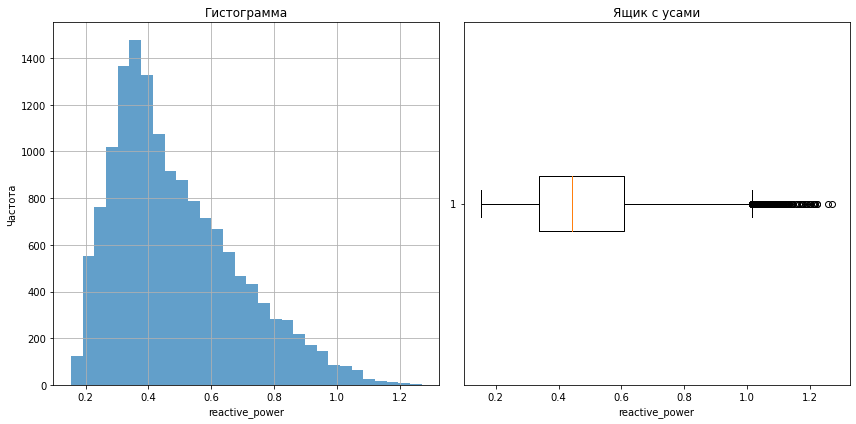

In [18]:
data_arc = data_arc.query('reactive_power > 0')
plot_histogram_boxplot(data_arc, 'reactive_power')

Добавим новые признаки, такие как полную мощность, время нагрева(разность между конечным и начальным), а также затраты на электроэнергию.

In [19]:
#Полная мощность
data_arc['real_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5
#Время нагрева
data_arc['heating_time'] = data_arc['end_heating'] - data_arc['start_heating']
data_arc['heating_time'] = data_arc['heating_time'].dt.seconds
#Затраты на электроэнергию
data_arc['electricity_costs'] = data_arc['real_power'] * data_arc['heating_time']

In [20]:
#Сгруппируем данные по "ключу"
data_arc = data_arc.groupby(by='key').sum()
data_arc.head()

,active_power,reactive_power,real_power,heating_time,electricity_costs
key,,,,,
1,3.036730,2.142821,3.718736,1098,770.282114
2,2.139408,1.453357,2.588349,811,481.760005
3,4.063641,2.937457,5.019223,655,722.837668
4,2.706489,2.056992,3.400038,741,683.455597
5,2.252950,1.687991,2.816980,869,512.169934


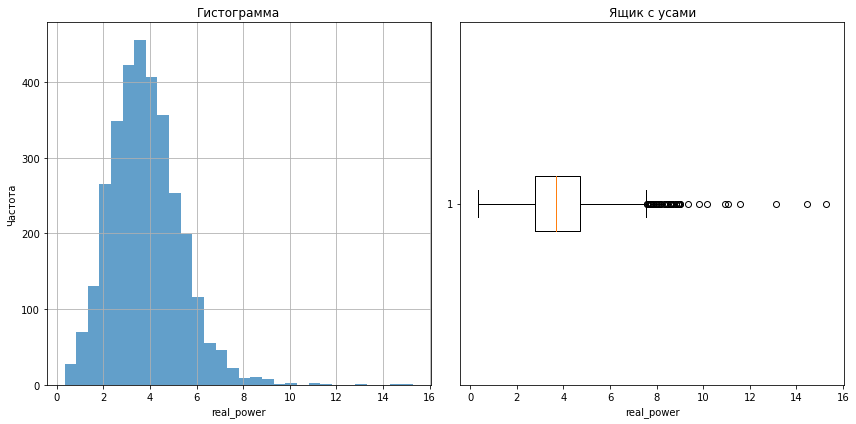

In [21]:
plot_histogram_boxplot(data_arc, 'real_power')

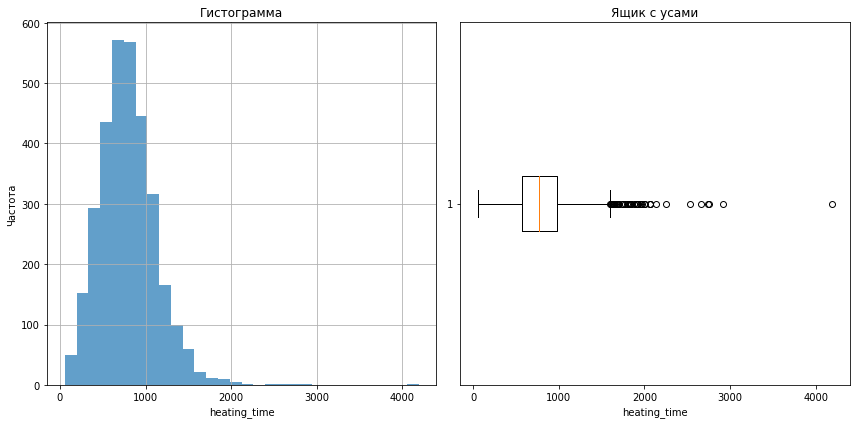

In [22]:
plot_histogram_boxplot(data_arc, 'heating_time')

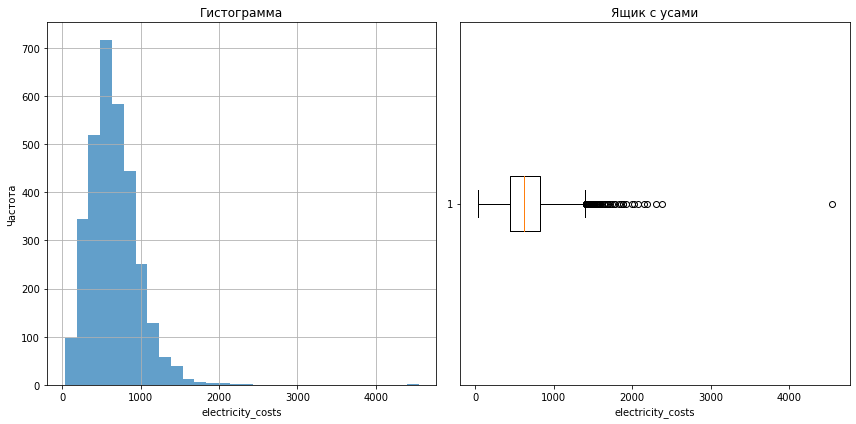

In [23]:
plot_histogram_boxplot(data_arc, 'electricity_costs')

# data_bulk

В данном датасете много пропусков, поработаем над этим

In [24]:
def percentage_missing(df):
    total = df.isnull().sum()
    percent = (total / len(df)) * 100
    return pd.DataFrame({'Количество пропусков': total, 'Процент пропусков': percent})

In [25]:
percentage_missing(data_bulk)

,Количество пропусков,Процент пропусков
key,0,0.000000
bulk_1,2877,91.946309
bulk_2,3107,99.296900
bulk_3,1831,58.517098
bulk_4,2115,67.593480
bulk_5,3052,97.539150
bulk_6,2553,81.591563
bulk_7,3104,99.201023
bulk_8,3128,99.968041
bulk_9,3110,99.392777


Удалим столбцы с пропусками, где их количство больше 80%, также заменим пропуски на нули в оставшихся столбцах и изменим их тип данных.

In [26]:
data_bulk.drop(['bulk_1','bulk_2', 'bulk_5', 'bulk_6', 
                'bulk_7','bulk_8', 'bulk_9', 'bulk_10', 
                'bulk_11', 'bulk_13'], axis= 1 , inplace= True)

In [27]:
data_bulk = data_bulk.fillna(0)
#Проверим
print(data_bulk.isna().sum())

data_bulk = data_bulk.astype('int')
#Проверим
display(data_bulk.head(),
        data_bulk.info())

key        0
bulk_3     0
bulk_4     0
bulk_12    0
bulk_14    0
bulk_15    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int64
 1   bulk_3   3129 non-null   int64
 2   bulk_4   3129 non-null   int64
 3   bulk_12  3129 non-null   int64
 4   bulk_14  3129 non-null   int64
 5   bulk_15  3129 non-null   int64
dtypes: int64(6)
memory usage: 146.8 KB


,key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
0,1,0,43,206,150,154
1,2,0,73,206,149,154
2,3,0,34,205,152,153
3,4,0,81,207,153,154
4,5,0,78,203,151,152


None

# gas

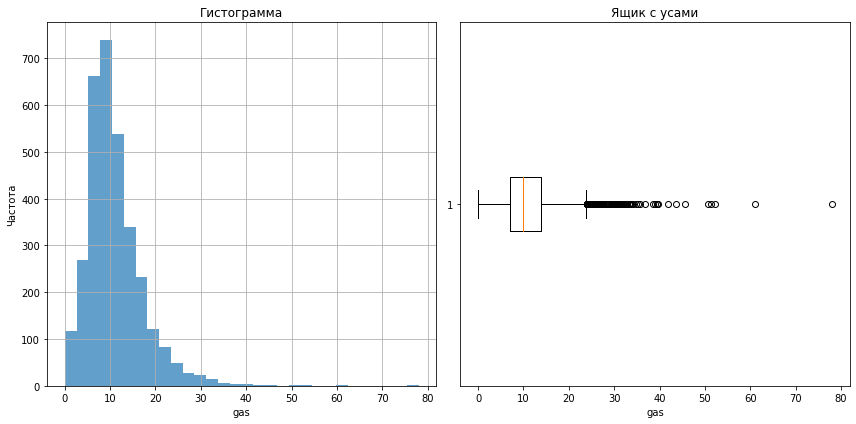

In [28]:
plot_histogram_boxplot(data_gas, 'gas')

# data_temp

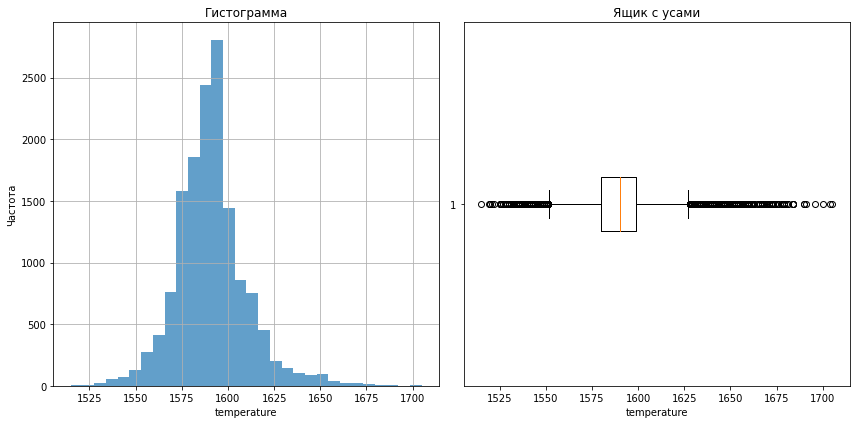

In [29]:
#Уберем значения температуры меньше 1500
data_temp = data_temp.query('temperature > 1500')
plot_histogram_boxplot(data_temp, 'temperature')

In [30]:
percentage_missing(data_temp)

,Количество пропусков,Процент пропусков
key,0,0.0
time,0,0.0
temperature,0,0.0


In [31]:
#Узнаем количество измерений температуры на каждой партии
measurement_rounds = data_temp['key'].value_counts().reset_index(name='measurement_rounds').rename(columns={'index': 'key'}).sort_values(by='key', ascending=False)
#Извлечем данные с одним измерением температуры
measurement_rounds.query('measurement_rounds > 1').head(15)

,key,measurement_rounds
1712,2499,5
968,2498,6
2298,2497,4
602,2496,7
1420,2495,5
1965,2494,4
2122,2493,4
2025,2492,4
966,2490,6
2342,2489,3


In [32]:
#Добавим признак с разницей между первым и последним замером по температуре
data_temp_fin = data_temp.groupby(by='key').agg(['first', 'last']).reset_index()
data_temp_fin.columns = ['key', 'first_time', 'finish_time', 'first_temp', 'finish_temp']
data_temp_fin['time_diff'] = data_temp_fin['finish_time'] - data_temp_fin['first_time']
data_temp_fin['time_diff'] = data_temp_fin['time_diff'].dt.seconds
#Также выведем данные по партиям, а именно меньше 2500, так как выше идут данные с одним измерением температуры
data_temp_fin = data_temp_fin.query('key < 2500')
data_temp_fin

,key,first_time,finish_time,first_temp,finish_temp,time_diff
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1714
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,1265
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,1753
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,1220
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,1536
...,...,...,...,...,...,...
2472,2495,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0,1380
2473,2496,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0,1705
2474,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0,962
2475,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,1591.0,1594.0,1520


# data_wire

In [33]:
percentage_missing(data_wire)

,Количество пропусков,Процент пропусков
key,0,0.000000
wire_1,26,0.843882
wire_2,2002,64.978903
wire_3,3018,97.955209
wire_4,3067,99.545602
wire_5,3080,99.967543
wire_6,3008,97.630639
wire_7,3070,99.642973
wire_8,3062,99.383317
wire_9,3052,99.058747


Поступим также, удалим столбцы с количеством пропусков больше 80% и заменим на 0 оставшиеся.

In [34]:
data_wire.drop(['wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'], axis= 1 , inplace= True )
data_wire = data_wire.fillna(0)
data_wire

,key,wire_1,wire_2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456
...,...,...,...
3076,3237,38.088959,0.00000
3077,3238,56.128799,0.00000
3078,3239,143.357761,0.00000
3079,3240,34.070400,0.00000


**ПРОМЕЖУТОЧНЫЙ ВЫВОД по "Исследовательскому анализу данных":** 

- обработали пропуски (удалили столбцы, где их количество больше 80% и оставшиеся заменили на 0);

- избавились от выбросов, аномалий;

- добавили новые признаки (real_power, heating_time, electricity_costs, first_time, finish_time, first_temp, finish_temp, time_diff);

- подготовили данные к объединению в общий датасет.

## Обединение данных

Для объединения используем все датасеты кроме data_bulk_time и data_wire_time, так как они не несут необходимой нам информации.

,key,active_power,reactive_power,real_power,heating_time,electricity_costs,first_time,finish_time,first_temp,finish_temp,time_diff,gas,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,1,3.036730,2.142821,3.718736,1098,770.282114,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1714,29.749986,0,43,206,150,154,60.059998,0.00000
1,2,2.139408,1.453357,2.588349,811,481.760005,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,1265,12.555561,0,73,206,149,154,96.052315,0.00000
2,3,4.063641,2.937457,5.019223,655,722.837668,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,1753,28.554793,0,34,205,152,153,91.160157,0.00000
3,4,2.706489,2.056992,3.400038,741,683.455597,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,1220,18.841219,0,81,207,153,154,89.063515,0.00000
4,5,2.252950,1.687991,2.816980,869,512.169934,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,1536,5.413692,0,78,203,151,152,89.238236,9.11456


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                2329 non-null   int64         
 1   active_power       2329 non-null   float64       
 2   reactive_power     2329 non-null   float64       
 3   real_power         2329 non-null   float64       
 4   heating_time       2329 non-null   int64         
 5   electricity_costs  2329 non-null   float64       
 6   first_time         2329 non-null   datetime64[ns]
 7   finish_time        2329 non-null   datetime64[ns]
 8   first_temp         2329 non-null   float64       
 9   finish_temp        2329 non-null   float64       
 10  time_diff          2329 non-null   int64         
 11  gas                2329 non-null   float64       
 12  bulk_3             2329 non-null   int64         
 13  bulk_4             2329 non-null   int64         
 14  bulk_12 

None

,key,active_power,reactive_power,real_power,heating_time,electricity_costs,first_temp,finish_temp,time_diff,gas,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1251.832546,3.125033,2.300522,3.884654,807.600687,669.741514,1587.386003,1593.365393,2321.810219,11.375600,47.348218,37.303564,208.415629,153.853585,119.952769,102.443601,17.609859
std,714.762400,1.221007,0.903968,1.518157,340.897332,319.531949,23.619841,11.200915,1385.191527,6.392041,75.310430,58.643238,157.062272,81.404354,84.640443,43.539993,33.624771
min,1.000000,0.267676,0.196228,0.331897,57.000000,33.430208,1519.000000,1541.000000,270.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,630.000000,2.293900,1.669572,2.843058,581.000000,457.864703,1571.000000,1587.000000,1579.000000,7.282948,0.000000,0.000000,105.000000,105.000000,0.000000,73.207679,0.000000
50%,1255.000000,3.035365,2.225398,3.767499,778.000000,630.714148,1587.000000,1593.000000,2045.000000,10.100950,0.000000,0.000000,206.000000,149.000000,107.000000,101.119201,0.000000
75%,1868.000000,3.834300,2.829159,4.769421,993.000000,841.398018,1603.000000,1598.000000,2791.000000,14.216688,80.000000,77.000000,282.000000,204.000000,204.000000,128.091599,23.102560
max,2499.000000,12.375636,8.949049,15.288271,4189.000000,4546.405812,1660.000000,1653.000000,23674.000000,77.995040,454.000000,281.000000,1849.000000,636.000000,405.000000,330.314424,282.780152


Количество дубликатов: 0
Количество пропусков: key                  0
active_power         0
reactive_power       0
real_power           0
heating_time         0
electricity_costs    0
first_time           0
finish_time          0
first_temp           0
finish_temp          0
time_diff            0
gas                  0
bulk_3               0
bulk_4               0
bulk_12              0
bulk_14              0
bulk_15              0
wire_1               0
wire_2               0
dtype: int64


,key,active_power,reactive_power,real_power,heating_time,electricity_costs,first_temp,finish_temp,time_diff,gas,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2
key,1.000000,-0.023422,-0.021349,-0.022668,-0.029519,-0.019351,-0.015911,-0.097242,-0.019979,-0.043486,-0.007271,-0.026147,0.025958,-0.110275,-0.045531,-0.013564,0.043149
active_power,-0.023422,1.000000,0.992424,0.999030,0.721249,0.818791,-0.154657,0.177339,0.539479,0.370985,0.103241,0.005563,0.286073,0.300046,0.169845,0.137923,0.062463
reactive_power,-0.021349,0.992424,1.000000,0.996868,0.713422,0.815386,-0.152598,0.171878,0.534577,0.367954,0.100949,0.004647,0.285721,0.295930,0.168109,0.138365,0.061848
real_power,-0.022668,0.999030,0.996868,1.000000,0.719734,0.819008,-0.154205,0.175668,0.538757,0.370555,0.102638,0.005236,0.286423,0.299090,0.169506,0.138347,0.062370
heating_time,-0.029519,0.721249,0.713422,0.719734,1.000000,0.900519,-0.384507,0.278716,0.562901,0.396306,0.092682,-0.028237,0.466789,0.461181,0.295854,0.055495,0.054543
electricity_costs,-0.019351,0.818791,0.815386,0.819008,0.900519,1.000000,-0.346087,0.256611,0.507737,0.354593,0.089667,-0.021429,0.421418,0.406482,0.273670,0.060219,0.047285
first_temp,-0.015911,-0.154657,-0.152598,-0.154205,-0.384507,-0.346087,1.000000,0.301320,0.209463,0.036047,-0.113925,0.164936,-0.080115,-0.181076,-0.063041,0.262598,-0.100733
finish_temp,-0.097242,0.177339,0.171878,0.175668,0.278716,0.256611,0.301320,1.000000,0.096447,0.059160,-0.035977,0.187970,0.267424,0.114617,0.266414,0.317575,-0.206672
time_diff,-0.019979,0.539479,0.534577,0.538757,0.562901,0.507737,0.209463,0.096447,1.000000,0.439295,0.022827,0.002708,0.210368,0.174947,0.100210,0.153379,0.060019
gas,-0.043486,0.370985,0.367954,0.370555,0.396306,0.354593,0.036047,0.059160,0.439295,1.000000,0.059628,0.017578,0.217332,0.268889,0.043624,0.117313,0.104248


Размер: (2329, 19)


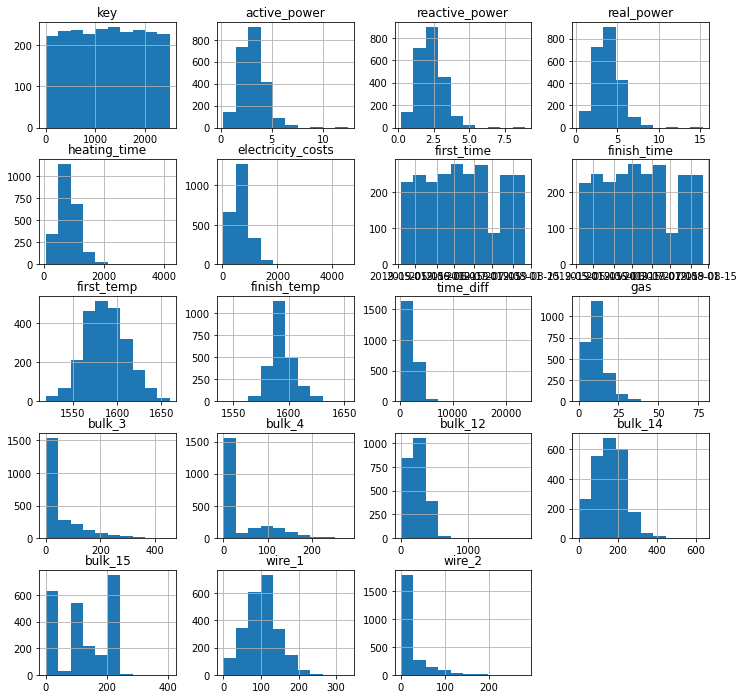

In [35]:
#Используем метод "inner"
df =  data_arc.merge(data_temp_fin, on='key', how='inner')
df = df.merge(data_gas, on='key', how='inner')
df = df.merge(data_bulk, on='key', how='inner')
df = df.merge(data_wire, on='key', how='inner')

info_about(df)

В целом объединение прошло успешно, типы данных в порядке, пропусков и дубликатов нет. Уберем ненужные признаки, а именно key, finish_time, first_time.

In [36]:
df.drop(['key', 'first_time', 'finish_time'], axis= 1 , inplace= True)
df

,active_power,reactive_power,real_power,heating_time,electricity_costs,first_temp,finish_temp,time_diff,gas,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,3.036730,2.142821,3.718736,1098,770.282114,1571.0,1613.0,1714,29.749986,0,43,206,150,154,60.059998,0.00000
1,2.139408,1.453357,2.588349,811,481.760005,1581.0,1602.0,1265,12.555561,0,73,206,149,154,96.052315,0.00000
2,4.063641,2.937457,5.019223,655,722.837668,1596.0,1599.0,1753,28.554793,0,34,205,152,153,91.160157,0.00000
3,2.706489,2.056992,3.400038,741,683.455597,1601.0,1625.0,1220,18.841219,0,81,207,153,154,89.063515,0.00000
4,2.252950,1.687991,2.816980,869,512.169934,1576.0,1602.0,1536,5.413692,0,78,203,151,152,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,3.168133,2.210936,3.868721,723,694.177326,1570.0,1591.0,1380,7.125735,21,0,256,129,223,89.150879,0.00000
2325,4.174918,2.872031,5.070316,940,815.818538,1554.0,1591.0,1705,9.412616,0,63,256,129,226,114.179527,0.00000
2326,3.605239,2.452092,4.360918,569,823.020520,1571.0,1589.0,962,6.271699,0,85,230,124,226,94.086723,9.04800
2327,3.202310,2.239820,3.909917,750,581.810739,1591.0,1594.0,1520,14.953657,90,0,206,129,207,118.110717,0.00000


**ПРОМЕЖУТОЧНЫЙ ВЫВОД по "Объединению данных":** 

- объединение прошло успешно;

- типы данных в порядке, пропусков, дубликатов нет;

- избавились от "ненужных" признаков key, finish_time, first_time;

- размер датасета 2329 строк и 16 столбцов.

## Исследовательский анализ данных объединенного датасета

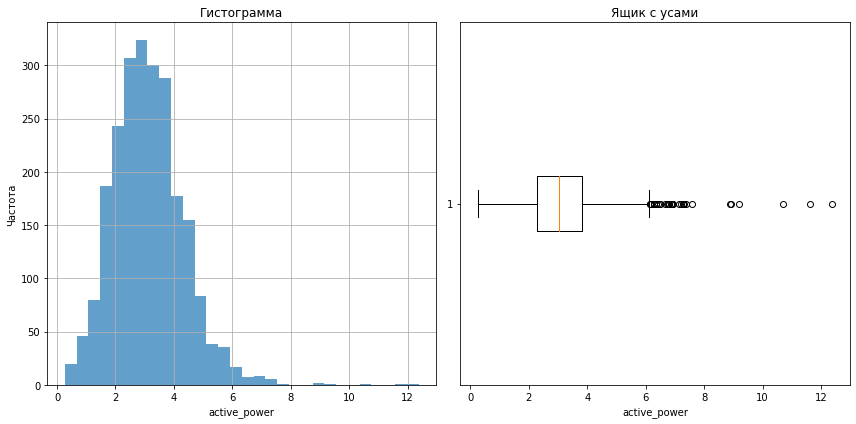

In [37]:
plot_histogram_boxplot(df, 'active_power')

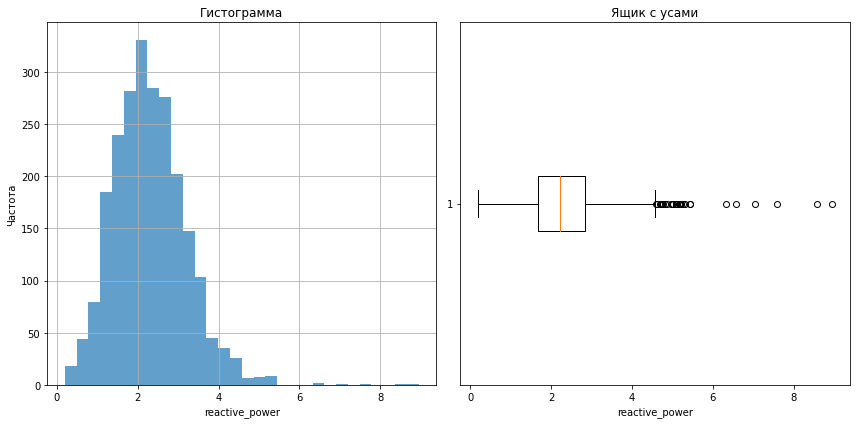

In [38]:
plot_histogram_boxplot(df, 'reactive_power')

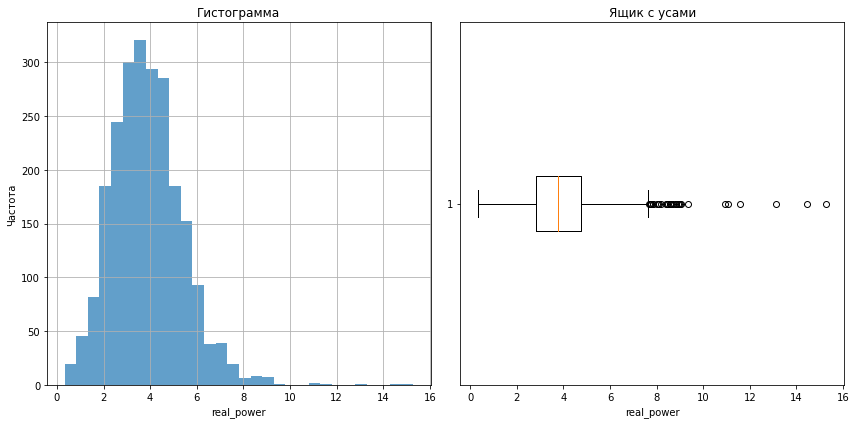

In [39]:
plot_histogram_boxplot(df, 'real_power')

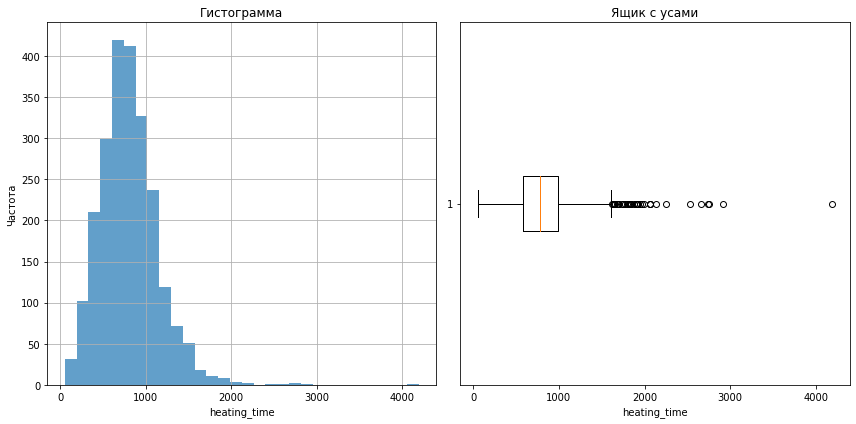

In [40]:
plot_histogram_boxplot(df, 'heating_time')

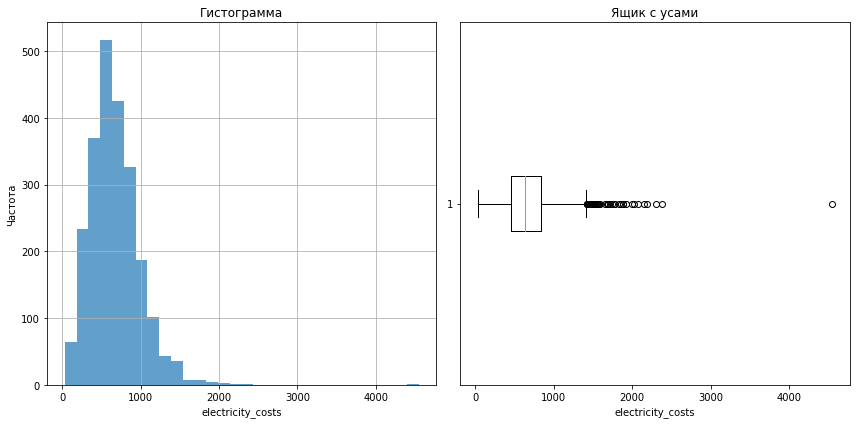

In [41]:
plot_histogram_boxplot(df, 'electricity_costs')

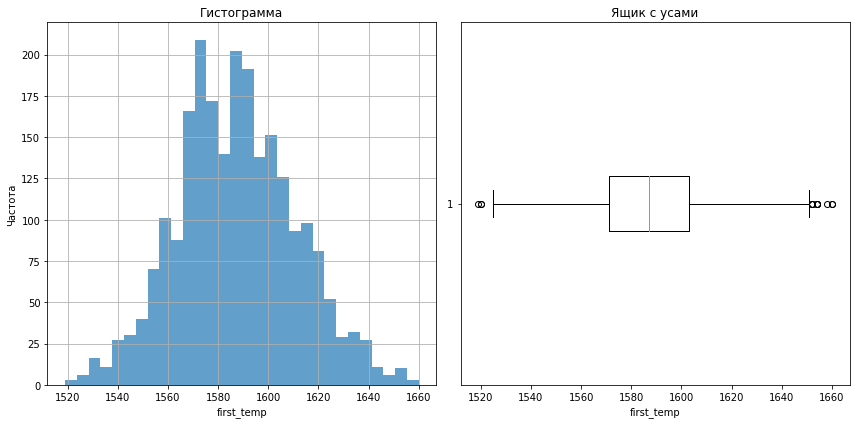

In [42]:
plot_histogram_boxplot(df, 'first_temp')

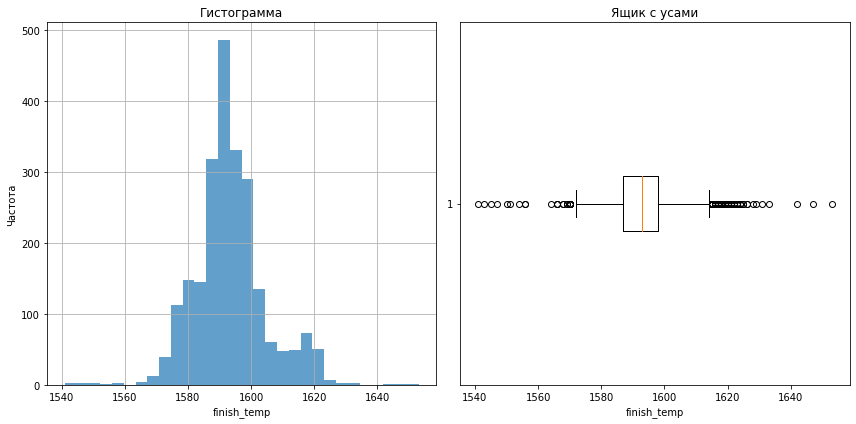

In [43]:
plot_histogram_boxplot(df, 'finish_temp')

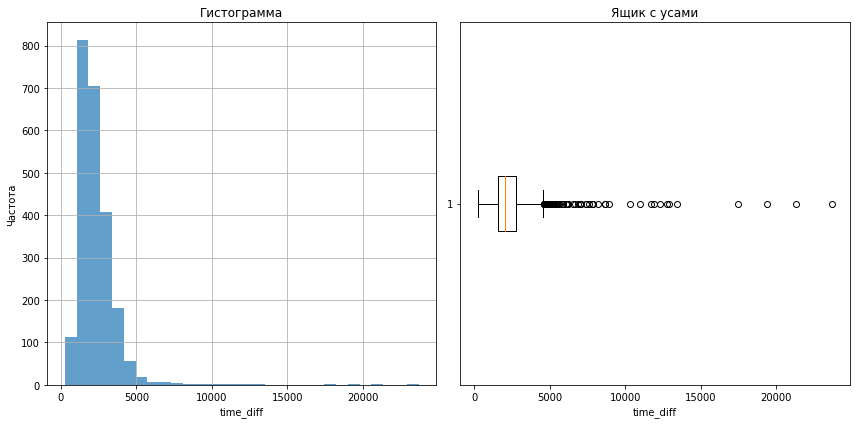

In [44]:
plot_histogram_boxplot(df, 'time_diff')

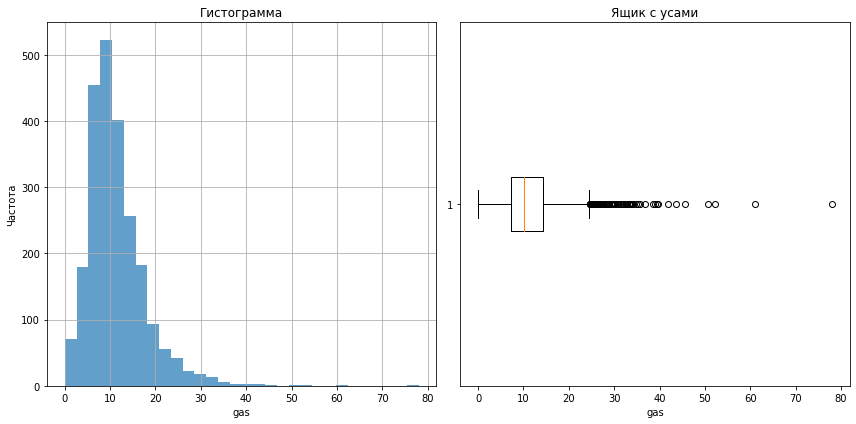

In [45]:
plot_histogram_boxplot(df, 'gas')

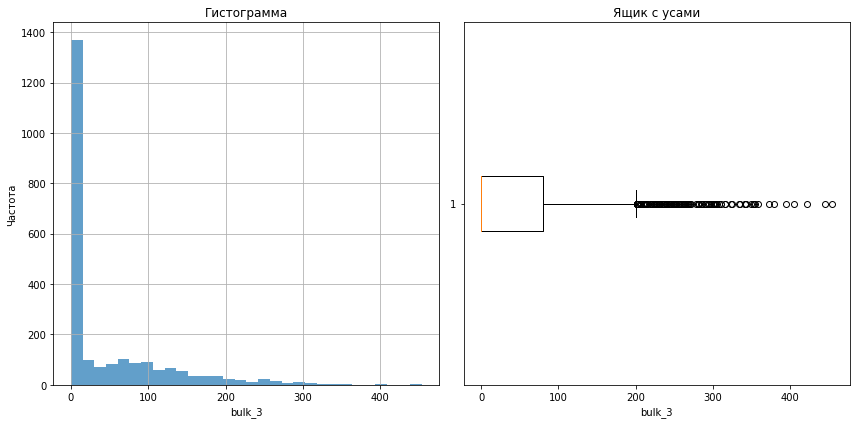

In [46]:
plot_histogram_boxplot(df, 'bulk_3')

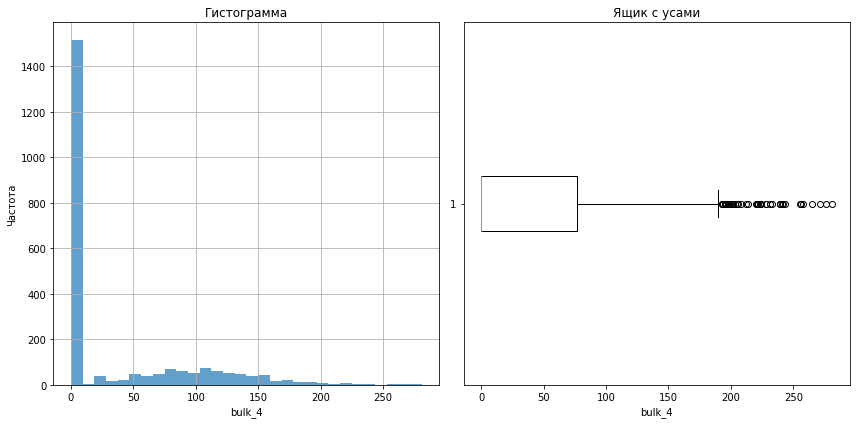

In [47]:
plot_histogram_boxplot(df, 'bulk_4')

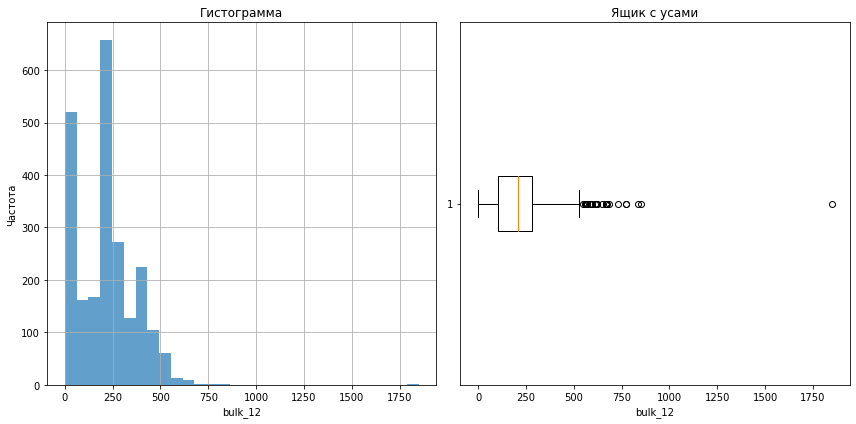

In [48]:
plot_histogram_boxplot(df, 'bulk_12')

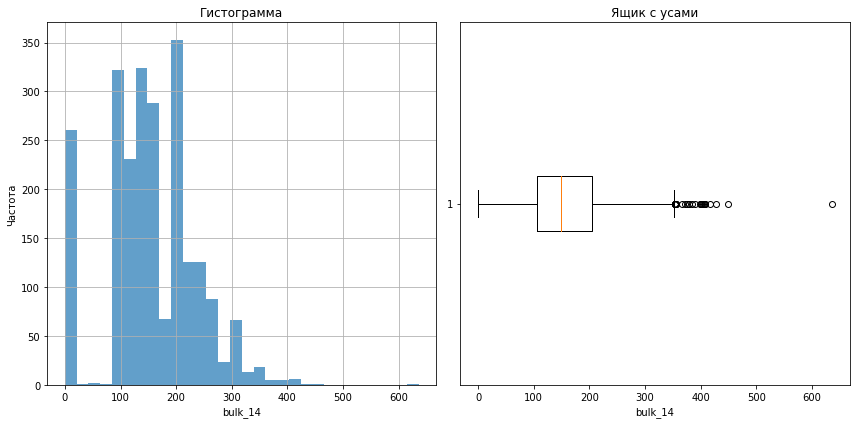

In [49]:
plot_histogram_boxplot(df, 'bulk_14')

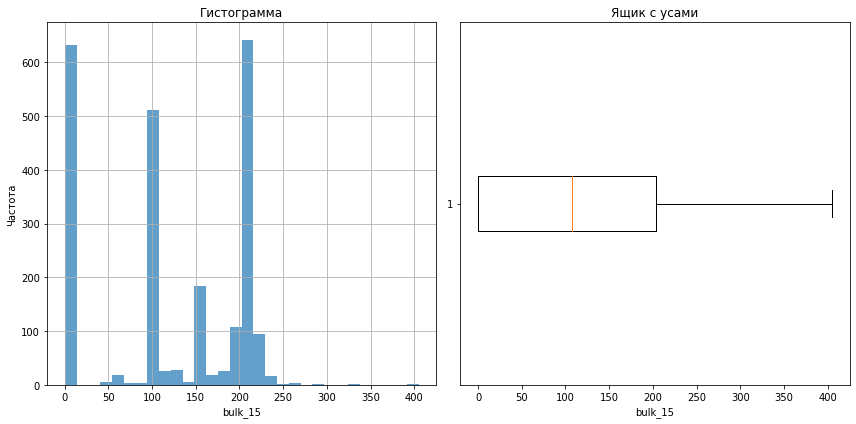

In [50]:
plot_histogram_boxplot(df, 'bulk_15')

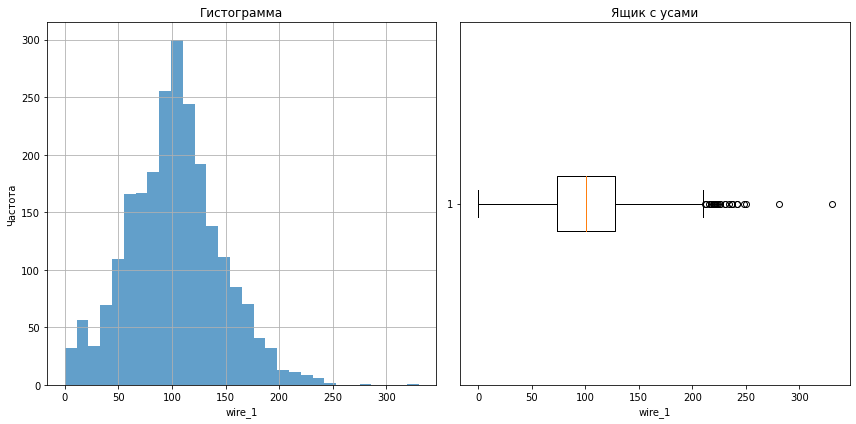

In [51]:
plot_histogram_boxplot(df, 'wire_1')

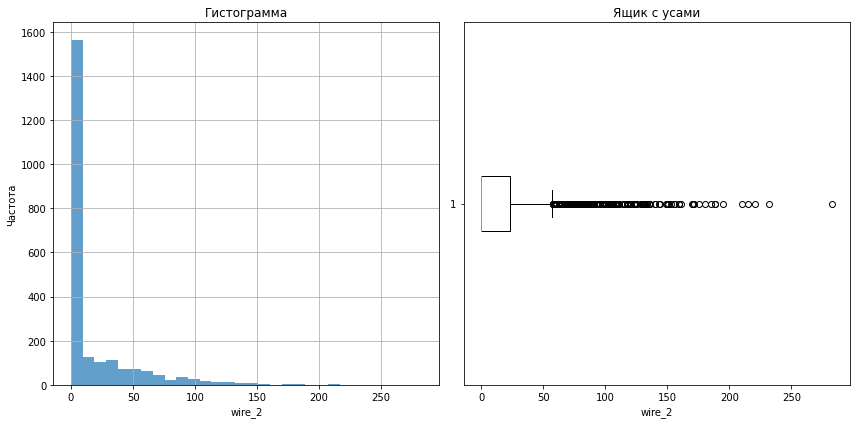

In [52]:
plot_histogram_boxplot(df, 'wire_2')

В целом почти у всех признаков нормальное распределение, за исключением bulk_3, bulk_4, bulk_15 и wire_2. Также присутствуют выбросы, их пока не трогаем. Далее построим тепловую карту корреляции.

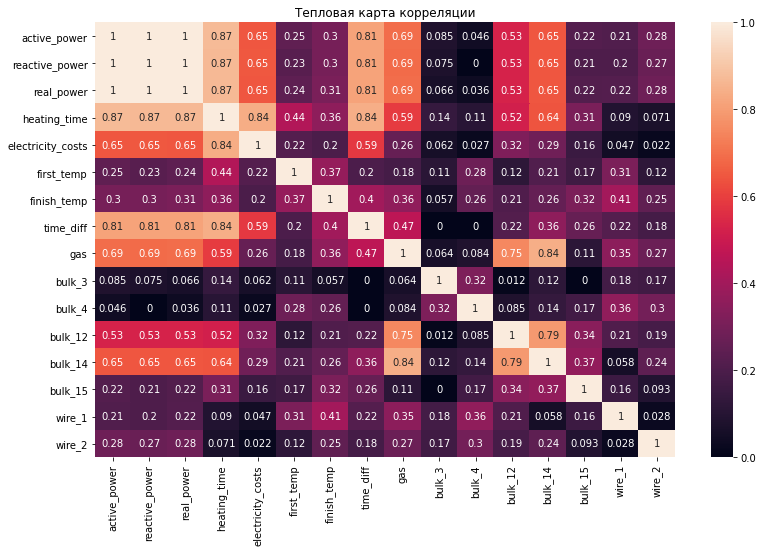

In [53]:
interval_cols = ['active_power', 'reactive_power', 'real_power', 'heating_time',
       'electricity_costs', 'first_temp', 'finish_temp', 'time_diff', 'gas',
       'bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1',
       'wire_2']

plt.figure(figsize=(13, 8))
sns.heatmap(df.phik_matrix(interval_cols=interval_cols, bins=6), annot=True) 
plt.title("Тепловая карта корреляции")
plt.show()

Имеется высокая корреляция между признаками "active_power", "reactive_power", "real_power", "heating_time".

**ПРОМЕЖУТОЧНЫЙ ВЫВОД по "Исследовательскому анализу данных объединенного датасета":** 

- в целом почти у всех признаков нормальное распределение, за исключением bulk_3, bulk_4, bulk_15 и wire_2;

- присутствуют выбросы, их не трогали;

- построили тепловую карту корреляции;

- обнаружили высокую корреляцию между признаками "active_power", "reactive_power", "real_power", "heating_time".

## Подготовка данных

Наш целевой признак - *конечная температура*.

In [54]:
#Поделим на выборки
X = df.drop('finish_temp', axis=1)
y = df['finish_temp']


X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE)

In [55]:
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1746, 15)

(583, 15)

(1746,)

(583,)

**ПРОМЕЖУТОЧНЫЙ ВЫВОД по "Подготовке данных":** 

- выделили целевой признак - "finish_temp";

- поделили данные на выборки в соотношении 3:1;

## Обучение моделей

**LinearRegression**

In [56]:
%%time

linear_model = LinearRegression()


mae_lr = cross_val_score(linear_model, X_train, 
                y_train, cv=5, 
                scoring='neg_mean_absolute_error').mean()
result_lr = abs(mae_lr)
print(f'MAE train: {result_lr:.2f}')

MAE train: 6.04
CPU times: user 92.3 ms, sys: 69.8 ms, total: 162 ms
Wall time: 115 ms


**RandomForestRegressor**

In [57]:
%%time

model = RandomForestRegressor()
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 4, 8],
    'bootstrap': [True, False],
    'random_state': [RANDOM_STATE]}
rf_grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
rf_grid.fit(X_train, y_train)
result_rf = abs(rf_grid.best_score_)
print(f'MAE train: {result_rf:.2f}')

MAE train: 6.13
CPU times: user 3min 14s, sys: 378 ms, total: 3min 14s
Wall time: 3min 15s


**CatBoostRegressor**

In [58]:
%%time

model = CatBoostRegressor(verbose=False)
params = {
    'loss_function':['MAE'],
    'depth': [5], 
    'learning_rate': [0.1], 
    'n_estimators': [500],  
    'random_state': [RANDOM_STATE],
}
cb_grid = GridSearchCV(model, params, cv=5,verbose=2, scoring='neg_mean_absolute_error')
cb_grid.fit(X_train, y_train)
result_cb = abs(cb_grid.best_score_)
print(f'MAE train: {result_cb:.2f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END depth=5, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=100225; total time=   1.9s
[CV] END depth=5, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=100225; total time=   1.9s
[CV] END depth=5, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=100225; total time=   2.0s
[CV] END depth=5, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=100225; total time=   2.1s
[CV] END depth=5, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=100225; total time=   2.0s
MAE train: 6.11
CPU times: user 6.93 s, sys: 216 ms, total: 7.15 s
Wall time: 11.9 s


In [59]:
print(cb_grid.best_params_)

{'depth': 5, 'learning_rate': 0.1, 'loss_function': 'MAE', 'n_estimators': 500, 'random_state': 100225}


**ПРОМЕЖУТОЧНЫЙ ВЫВОД по "Обучению моделей":** 

- в обучении использовали такие модели как LinearRegression, RandomForestRegressor, CatBoostRegressor;

- MAE LinearRegression = 6.04;

- MAE RandomForestRegressor = 6.13;

- MAE CatBoostRegressor = 6.11, где лучшие параметры:  {'depth': 5, 'learning_rate': 0.1, 'loss_function': 'MAE', 'n_estimators': 500, 'random_state': 100225}

## Выбор лучшей модели

In [60]:
df_result = {'MAE train':[result_lr, result_rf, result_cb]}
index = ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor']
data_final = pd.DataFrame(data=df_result, index=index)
pd.set_option('precision', 2)
display(data_final.sort_values(by='MAE train', ascending=True))

,MAE train
LinearRegression,6.04
CatBoostRegressor,6.11
RandomForestRegressor,6.13


LinearRegression со значением метрики MAE равным 6.04 показала себя с лучшей стороны на тренировочной выборке. Проверим ее на тестовой.

In [61]:
%%time

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE test: {mae:.2f}')

MAE test: 6.19
CPU times: user 23.3 ms, sys: 53 µs, total: 23.4 ms
Wall time: 8.78 ms


На тестовой выборке модель показала значение 6.19 что соответствует условию заказчика.

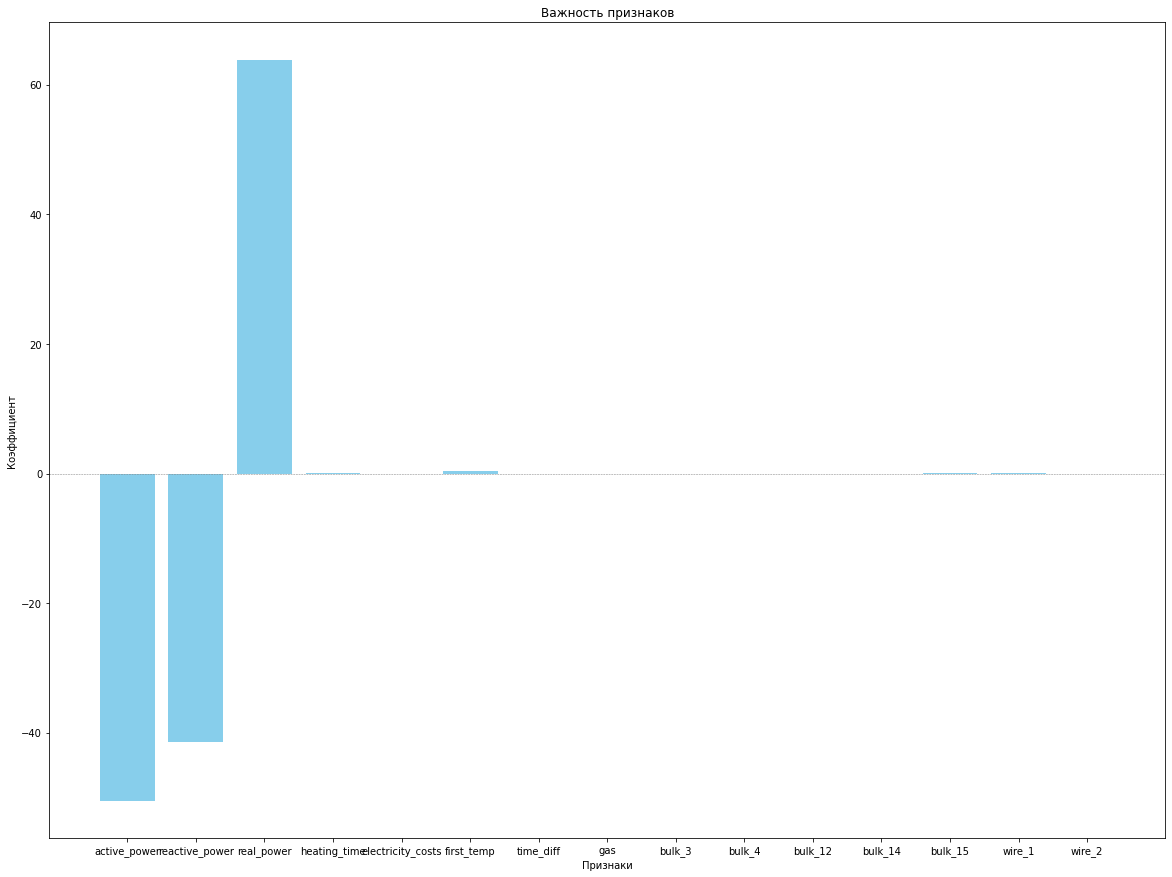

In [62]:
importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Coefficient': model.coef_})

plt.figure(figsize=(20, 15))
plt.bar(importance['Feature'], importance['Coefficient'], color='skyblue')
plt.title('Важность признаков')
plt.xlabel('Признаки')
plt.ylabel('Коэффициент')
plt.axhline(0, color='grey', linewidth=0.5, linestyle='--')
plt.show()

Для модели наиболее важным признаком является полная мощность (real_power).

In [63]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_predictions = dummy_regr.predict(y_test)
mean_absolute_error(y_test, dummy_predictions)
print(f'MAE constant test: {mean_absolute_error(y_test, dummy_predictions):.2f}')

MAE constant test: 7.99


LinearRegression показала результат лучше чем на константной модели DummyRegressor.

## Общий вывод

**Цель нашего проекта была**: построить модель, которая будет её предсказывать. 

**Также были критерии оценки**:
    
- качество модели оцениваем по метрике MAE;

- минимальный порог для выполнения условий заказчика: MAE = 6.8.

**Нам были предоставлены следующие датасеты**:

*data_arc_new.csv* - данные об электродах, *data_bulk_new.csv* - данные о подаче сыпучих материалов (объём), *data_bulk_time_new.csv* - данные о подаче сыпучих материалов (время), *data_gas_new.csv* - данные о продувке сплава газом, *data_temp_new.csv* - результаты измерения температуры, *data_wire_new.csv* - данные о проволочных материалах (объём), *data_wire_time_new.csv* - данные о проволочных материалах (время).

**В процессе предобработки и исследовательском анализе данных были совершены следующие действия**:

- привели столбцы к единообразию и "змеиному регистру";

- изменили типы данных в столбцах, где это необходимо;

- обработали пропуски (удалили столбцы, где их количество больше 80% и оставшиеся заменили на 0);

- избавились от выбросов, аномалий;

- добавили новые признаки (real_power, heating_time, electricity_costs, first_time, finish_time, first_temp, finish_temp, time_diff);

**Далее объединили данные в единый датасет, где**:

- типы данных в порядке, пропусков и дубликатов не оказалось;

- избавились от "ненужных" признаков key, finish_time, first_time;

- размер датасета составил 2329 строк и 16 столбцов.

**Проанализировав объединенный датасет пришли к выводам, что**:

- в целом почти у всех признаков нормальное распределение, за исключением bulk_3, bulk_4, bulk_15 и wire_2;

- присутствуют выбросы, их не трогали;

- построили тепловую карту корреляции;

- обнаружили высокую корреляцию между признаками "active_power", "reactive_power", "real_power", "heating_time".

**Провели обучение моделей на тренировочной выборке, используя такие модели как**:

- LinearRegression с MAE = 6.04; 
- RandomForestRegressor с MAE = 6.13;
- CatBoostRegressor с MAE = 6.11.

**Лучшей моделью оказалась LinearRegression, которая на тестовой выборке дала результат значения метрики MAE = 6.19, показав себя в сравнении с константной моделью DummyRegressor (MAE = 7.99) с "наилучшей стороны".**

**Выявили важность признаков, коим оказался признак real_power(полная мощность).**

## Рекомендации

- Обратить внимание на точность и своевременную запись замеров температур;

- Выяснить причину возникновения большого количества выбросов;

- Для меньшего потребления электроэнергии, что взаимосвязано с мощностью, необходимо контролировать температуру сплава.